In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import climate
import numpy as np

C:\Users\tgerrish\AppData\Local\Continuum\anaconda3\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\tgerrish\AppData\Local\Continuum\anaconda3\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\tgerrish\AppData\Local\Continuum\anaconda3\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\tgerrish\AppData\Local\Continuum\anaconda3\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWar

In [4]:
# Load EPW file
w = climate.weather.Weather("./test/weatherfile_AlBateen.epw").read_epw()

# Generate sky matrices
smx = climate.sky.SkyMatrix(w.to_wea())

EPW loaded: C:\Users\tgerrish\Documents\GitHub\climate\test\weatherfile_AlBateen.epw
WEA file created: C:\Users\tgerrish\Documents\GitHub\climate\test\weatherfile_AlBateen.wea
Direct sky matrix calculated: C:\Users\tgerrish\Documents\GitHub\climate\test\weatherfile_AlBateen.dirmtx
Diffuse sky matrix calculated: C:\Users\tgerrish\Documents\GitHub\climate\test\weatherfile_AlBateen.diffmtx


In [58]:
# Create sample rays
sample_points = climate.geometry.fibonacci_sphere(n_points=1000)

# Resample sky matrix
sample_radiation = smx.resample(sample_points=sample_points, _type="total", n_closest=3)

# Get the angle between sample point and horizon (altitude angle)
sample_point_altitude = climate.geometry.vector_horizon_angle(sample_points)

# Calculate the radiation flux on open ground
ground_radiation_flux = climate.sky.incident_radiation_at_angle(sample_radiation, sample_point_altitude, degrees=False)

# Calculate view factor for a body to each sample point
body_view_factor = climate.geometry.view_factor(sample_points)

# Calculate radiation from the sky
sky_sourced_radiation = (body_view_factor * sample_radiation).sum(axis=1)

# Specify ground material
gnd = climate.material.OpaqueMaterial(
    conductivity=1, 
    volumetric_heat_capacity=200, 
    specific_heat_capacity=200, 
    reflectivity=0.5, 
    emissivity=0.5, 
    thickness=1, 
    roughness="Medium rough", 
    name="Ground"
)

# Calculate radiation reflected by the ground
ground_reflected_sky_radiation = (np.power(ground_albedo, ray_intersected_points) * sky_sourced_radiation).sum(axis=1)



C:\Users\tgerrish\Documents\GitHub\climate\climate\sky.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
C:\Users\tgerrish\Documents\GitHub\climate\climate\sky.py:43: RuntimeWarning: invalid value encountered in true_divide
  return np.array(sample_values)


In [57]:
(body_view_factor * sample_radiation).sum(axis=1).shape

(8760,)

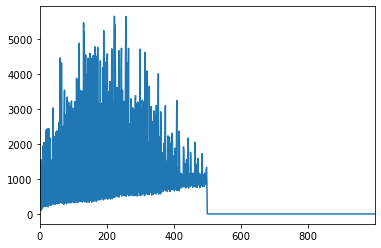

In [52]:
pd.Series((body_view_factor * sample_radiation).sum(axis=0)).plot()

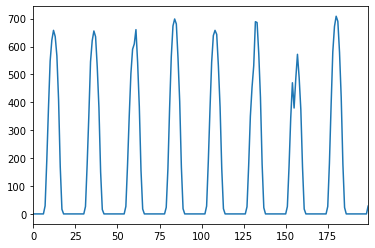

In [26]:
radiation_on_square_metre(sample_points, sample_radiation))

In [13]:
from climate.sky import SkyMatrix

smx = SkyMatrix(wea_file=w.wea_path, reinhart=True)
climate.sky.resample_sky_matrix(sample_points, smx.patch_centroids, smx.total_sky_matrix)

Direct sky matrix calculated: C:\Users\tgerrish\Documents\GitHub\climate\test\weatherfile_AlBateen.dirmtx
Diffuse sky matrix calculated: C:\Users\tgerrish\Documents\GitHub\climate\test\weatherfile_AlBateen.diffmtx


C:\Users\tgerrish\Documents\GitHub\climate\climate\sky.py:41: RuntimeWarning: invalid value encountered in true_divide
  np.where(n_values != 0, n_values / sampled_total_hour_radiation * known_total_hour_radiation, 0))


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Generate source data for testing
import pandas as pd
import matplotlib.pyplot as plt

def resample_sky_matrix(sample_points, known_points, known_values):
    sample_distances, sample_indices = climate.geometry.closest_point(sample_points, known_points, n_closest=3)

    sample_values = []
    for hour in known_values:
        n_values = (hour[sample_indices] * sample_distances).sum(axis=1) / sample_distances.sum(axis=1)
        n_values = np.where(sample_points[:, 2] <= 0, 0, n_values)  # Replace values where vectors are below ground
        known_total_hour_radiation = sum(hour)  # Total hourly radiation from original sky matrix
        sampled_total_hour_radiation = sum(n_values)  # Total hourly radiation from sampled sky matrix
        sample_values.append(np.where(n_values != 0, n_values / sampled_total_hour_radiation * known_total_hour_radiation, 0))
    
    return np.array(sample_values)
    
    
known_points = smx.patch_centroids
known_values = smx.total_sky_matrix
sample_points = climate.geometry.fibonacci_sphere(500)

resample_sky_matrix(sample_points, known_points, known_values)

# sample_distances, sample_indices = climate.geometry.closest_point(sample_points, known_points, n_closest=3)

# sample_values = []
# for hour in known_values:
#     n_values = (hour[sample_indices] * sample_distances).sum(axis=1) / sample_distances.sum(axis=1)
#     n_values = np.where(sample_points[:, 2] <= 0, 0, n_values)  # Replace values where vectors are below ground
#     known_total_hour_radiation = sum(hour)  # Total hourly radiation from original sky matrix
#     sampled_total_hour_radiation = sum(n_values)  # Total hourly radiation from sampled sky matrix
#     sample_values.append(np.where(n_values != 0, n_values / sampled_total_hour_radiation * known_total_hour_radiation, 0))
# sample_values = np.array(sample_values)
# pd.Series(sample_values.sum(axis=1)).plot()

In [ ]:
# New method testing
sample_vector_closest_patch_vector_distances, sample_vector_closest_patch_vector_indices = climate.geometry.closest_point(sample_points, known_points, n_closest=3)
sample_vector_radiation = []
for total_sky_matrix_hour in known_values[12:13]:
    n_values = (total_sky_matrix_hour[sample_vector_closest_patch_vector_indices] * sample_vector_closest_patch_vector_distances).sum(axis=1) / sample_vector_closest_patch_vector_distances.sum(axis=1)
    
print(n_values[0:6])

# (((known_values[:, sample_vector_closest_patch_vector_indices] * sample_vector_closest_patch_vector_distances).sum(axis=1)) / sample_vector_closest_patch_vector_distances.sum(axis=1).T)[12:13, :], n_values

In [ ]:
# Old method from Navid
sample_vector_closest_patch_vector_distances, sample_vector_closest_patch_vector_indices = climate.geometry.closest_point(sample_points, known_points, n_closest=3)
sample_vector_radiation = []
for total_sky_matrix_hour in known_values:
    n_values = (total_sky_matrix_hour[sample_vector_closest_patch_vector_indices] * sample_vector_closest_patch_vector_distances).sum(axis=1) / sample_vector_closest_patch_vector_distances.sum(axis=1)
    n_values = np.where(sample_points[:, 2] <= 0, 0, n_values)  # Replace values where vectors are below ground
    total_sky_matrix_hour_radiation = sum(total_sky_matrix_hour)  # Total hourly radiation from original sky matrix
    resampled_sky_matrix_hour_radiation = sum(n_values)  # Total hourly radiation from sampled sky matrix
    sample_vector_radiation.append(np.where(n_values != 0, n_values / resampled_sky_matrix_hour_radiation * total_sky_matrix_hour_radiation, 0))
sample_vector_radiation = np.array(sample_vector_radiation)
pd.Series(sample_vector_radiation.sum(axis=1)).plot()

In [ ]:
dist, idx = climate.geometry.closest_point(sample_points, known_points, n_closest=3)
pd.Series((((known_values[:, idx] * dist) / dist.sum()).sum(axis=2) * (sample_points[:, 2] > 0)).sum(axis=1)).plot()

# (sample_points[:, 2] > 0).shape
# idx.shape

In [ ]:
# NEw method from me!
# Interpolate values on sphere using cartesian coordinates
def interpolate_3d(sample_points, known_points, known_values, n_closest=3):
    dist, idx = climate.geometry.closest_point(sample_points, known_points, n_closest=n_closest)
    return ((known_values[:, idx] * dist) / dist.sum()).sum(axis=2)

def interpolate_3d_new(sample_points, known_points, known_values, n_closest=3):
    dist, idx = climate.geometry.closest_point(sample_points, known_points, n_closest=n_closest)
    n_values = (known_values[:, idx] * dist).sum(axis=1) / dist.sum(axis=1)
    return n_values



fig, ax = plt.subplots(1, 1, figsize=(15, 7))
pd.Series(interpolate_3d(sample_points, known_points, known_values, n_closest=3).sum(axis=1)*100).plot(ax=ax, label="TG", alpha=0.5, c="blue")
pd.Series(sample_vector_radiation.sum(axis=1)).plot(ax=ax, label="NH", alpha=0.5, c="red")

interpolate_3d_new(sample_points, known_points, known_values, n_closest=3), n_values

In [ ]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator, griddata

for n, i in enumerate(known_points):
    print("({0:>5.2f}, {1:>5.2f}, {2:>5.2f})".format(i[0], i[1], i[2]), known_values[n])
print()

#####################

sp = NearestNDInterpolator(known_points, known_values)(sample_points)

for n, pt in enumerate(sample_points):
    print("({0:>5.2f}, {1:>5.2f}, {2:>5.2f})".format(pt[0], pt[1], pt[2]), sp[n])
print()

#####################

sp = LinearNDInterpolator(known_points, known_values)(sample_points)

for n, pt in enumerate(sample_points):
    print("({0:>5.2f}, {1:>5.2f}, {2:>5.2f})".format(pt[0], pt[1], pt[2]), sp[n])

print()
sp = griddata(known_points, known_values, sample_points, method="cubic")

for n, pt in enumerate(sample_points):
    print("({0:>5.2f}, {1:>5.2f}, {2:>5.2f})".format(pt[0], pt[1], pt[2]), sp[n])
print()

In [ ]:
import scipy.interpolate
import numpy
class LinearNDInterpolatorExt(object):
    def __init__(self, points,values):
        self.funcinterp=scipy.interpolate.LinearNDInterpolator(points,values)
        self.funcnearest=scipy.interpolate.NearestNDInterpolator(points,values)
    def __call__(self,*args):
        t=self.funcinterp(*args)
        if not numpy.isnan(t):
            return t.item(0)
        else:
            return self.funcnearest(*args)

LinearNDInterpolatorExt(known_points, known_values)(sample_points[3])

In [ ]:
from climate.sun import SkyMatrix
from climate.mrt import generate_numerous_vectors
from scipy.interpolate import LinearNDInterpolator

In [ ]:
smx = SkyMatrix(wea_file=w.wea_path, reinhart=True)

In [ ]:
nv = generate_numerous_vectors(samples=250)

In [ ]:
def unit_vector(vector):
    """
    Returns the angle between vectors 'v1' and 'v2'

    Parameters
    ----------
    vector : vector
        Non-unitized n-dimensional vector

    Returns
    -------
    unit_vector : ndarray
        The unitized form of the input vector
    """
    return vector / np.linalg.norm(vector)

unit_vector(nv)[0:5], nv[0:5]

In [ ]:
LinearNDInterpolator(smx.patch_centroids, smx.total_sky_matrix.T)(unit_vector(nv)).T
# smx.patch_centroids, smx.total_sky_matrix.T

In [ ]:
from scipy.interpolate import LinearNDInterpolator


sample_points = generate_numerous_vectors(samples=100)

# smx.resample_total_sky_matrix(sample_points)

# Sample points to return values for in sky matrix
sample_points = np.stack([smx.patch_centroids[0:3, :].mean(axis=0), smx.patch_centroids[180:183, :].mean(axis=0), smx.patch_centroids[2:5, :].mean(axis=0)], axis=0)

# Resample
# LinearNDInterpolator(smx.patch_centroids, smx.total_sky_matrix.T)(sample_points).T

sample_points

In [ ]:
from climate.sun import closest_point

# Sample skymatrix at point/s
sample_points = np.stack([smx.patch_centroids[0:3, :].mean(axis=0), smx.patch_centroids[2:5, :].mean(axis=0)], axis=0)

# Get nearby points and index locations
target_distances, target_indices = closest_point(sample_points, smx.patch_centroids, n_closest=3)

# Get distance weighted (interpolated) values for nearby points
sample_vector_radiation = []
for total_sky_matrix_hour in smx.total_sky_matrix:
    n_values = (total_sky_matrix_hour[target_indices] * target_distances).sum(axis=1) / target_distances.sum(axis=1)
    n_values = np.where(sample_points[:, 2] <= 0, 0, n_values)  # Replace values where vectors are below ground
    total_sky_matrix_hour_radiation = sum(total_sky_matrix_hour)  # Total hourly radiation from original sky matrix
    resampled_sky_matrix_hour_radiation = sum(n_values)  # Total hourly radiation from sampled sky matrix
    sample_vector_radiation.append(np.where(n_values != 0, n_values / resampled_sky_matrix_hour_radiation * total_sky_matrix_hour_radiation, 0))
sample_vector_radiation = np.array(sample_vector_radiation)


sample_vector_radiation

# smx.patch_centroids[0:2, :].mean(axis=0), smx.patch_centroids[2:3, :].mean(axis=0), smx.patch_centroids

In [ ]:
from climate.mrt import generate_numerous_vectors, vector_horizon_angle, sky_view_factor, incident_radiation_at_angle

# Calculate cumulative radiation flux

# Sky matrix
tsm = w.total_sky_matrix

# Numerous vectors
nv = climate.mrt.generate_numerous_vectors(samples=1000)

# Vector horizon angle
vha = climate.mrt.vector_horizon_angle(nv)

# Sky view factor
svf = climate.mrt.sky_view_factor(nv)


# Get radiation at each NV sample point
# nv[vha > 0]

(tsm[nv_idx].T * nv_dist.T).T.shape


# Metre square radiation


# incident_radiation_at_angle(100, 3.14159/2, degrees=False)

# # Ground material definition
# m = climate.material.OpaqueMaterial(
#     conductivity=0.5, 
#     volumetric_heat_capacity=0.5, 
#     specific_heat_capacity=0.5, 
#     reflectivity=0.5, 
#     emissivity=0.5, 
#     thickness=1, 
#     roughness="Medium rough", 
#     name="Ground"
# )

# m.surface_temperature(
#     dry_bulb_temperature=12, 
#     local_wind_speed=0.1, 
#     radiation_flux=13, 
#     material_temperature=12, 
#     kelvin=False
# )

In [ ]:
climate.mrt.resample_sky_matrix(tsm, climate.constants.REINHART_PATCH_CENTROIDS, nv, n_closest=3)

In [ ]:
# Resample sky matrix to get distance and index of the sample points
nv_dist, nv_idx = climate.mrt.closest_point(nv, climate.constants.REINHART_PATCH_CENTROIDS, n_closest=3)

# Get the interpolated radiation at the resampled point for each hour of the year
# (tsm.T[nv_idx] * nv_dist / 3).shape
((tsm.T[nv_idx].T * nv_dist.T) / nv_dist.T.sum()).sum(axis=1).sum()

In [ ]:
tsm[nv_idx]

print(tsm[nv_idx].shape, tsm.shape, nv_dist.shape)

((tsm.T[nv_idx].T * nv_idx.T) * nv_dist.T).shape#.sum(axis=1).sum()

In [ ]:
import numpy as np

def sample_vector_radiation1(sky_matrix, nv_idx, nv_dist):
    sample_vector_radiation = []
    for total_sky_matrix_hour in sky_matrix:
        n_values = (total_sky_matrix_hour[nv_idx] * nv_dist).sum(axis=1) / nv_dist.sum(axis=1)
        n_values = np.where(nv[:, 2] <= 0, 0, n_values)  # Replace values where vectors are below ground
        total_sky_matrix_hour_radiation = sum(total_sky_matrix_hour)  # Total hourly radiation from original sky matrix
        resampled_sky_matrix_hour_radiation = sum(n_values)  # Total hourly radiation from sampled sky matrix
        sample_vector_radiation.append(np.where(n_values != 0, n_values / resampled_sky_matrix_hour_radiation * total_sky_matrix_hour_radiation, 0))
    return np.array(sample_vector_radiation)

sample_vector_radiation1(tsm, nv_idx, nv_dist).sum()

In [ ]:
angle_between([[vector[0], vector[1], 0], [vector[0], vector[1], 0]], vector, degrees=True)

In [ ]:

# vv[:, 0]
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection="3d")
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_zlim(-1, 1)

# vector, theta, sky = generate_numerous_vectors(samples=100)
# x, y, z = vector.T
# ax.scatter(x, y, z, c=z, cmap="rainbow")

# ax.scatter(x[sky], y[sky], z[sky], c="k", s=20)
# ax.view_init(elev=0, azim=0)

# for x, y, z, t in zip(x, y, z, theta):
#     ax.text(x, y, z, "{0:0.2f}".format(t))
# # np.fabs(np.arctan(z / np.sqrt(np.power(x, 2) + np.power(y, 2))))
# # theta

In [ ]:
from climate.material import OpaqueMaterial

o = OpaqueMaterial(
    conductivity=0.2, 
    volumetric_heat_capacity=1, 
    specific_heat_capacity=1.0, 
    reflectivity=0.1, 
    emissivity=0.9, 
    thickness=1.6, 
    roughness="Medium rough"
)

o.surface_temperature(
    dry_bulb_temperature=20, 
    material_temperature=20, 
    radiation_flux=600, 
    local_wind_speed=10
)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# for ws in range(0, 21, 4):
#     ax.scatter(ws, o.surface_temperature(
#     dry_bulb_temperature=20, 
#     material_temperature=20, 
#     radiation_flux=600, 
#     local_wind_speed=ws
# ))

# for rad in range(0, 1201, 100):
#     ax.scatter(rad, o.surface_temperature(
#     dry_bulb_temperature=20, 
#     material_temperature=20, 
#     radiation_flux=rad, 
#     local_wind_speed=4
# ))

# for dbt in range(0, 31, 2):
#     ax.scatter(dbt, o.surface_temperature(
#     dry_bulb_temperature=dbt, 
#     material_temperature=20, 
#     radiation_flux=500, 
#     local_wind_speed=4
# ))

In [ ]:
import numpy as np
np.interp(np.power(45, 3), [0, 1e6], [0.33, 1.4])  # TODO: Check what this value is and where it comes from!

In [ ]:
b = weather.Weather()
b.read_pickle(pickle_path="./test/weatherfile_AlBateen.pkl")

In [ ]:



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

########################################

from climate.core import Weather

# Load weather
epw_file = "./test/weatherfile_AlBateen.epw"
weather = Weather(epw_file).read_epw()

#     sun_position=True, 
#     pedestrian_wind=True, 
#     psychrometrics=True, 
#     ground_temp=True, 
#     sky_matrix=True, 
#     mrt=True, 
#     utci=True, 
#     _set=False,
#     uwg=False
# )

# weather.plot()

In [ ]:
weather.dry_bulb_temperature

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
weather.dry_bulb_temperature.plot()
weather.ground_temperature_500_weatherfile.plot()
weather.ground_temperature_calculated.plot()

# weather.dry_bulb_temperature[weather.wind_speed <= 1].plot()
# print(weather.dry_bulb_temperature)

In [ ]:
serieses = [weather.universal_thermal_climate_index_openfield, weather.universal_thermal_climate_index_solar_adjusted, weather.universal_thermal_climate_index_openfield * 0.95, weather.universal_thermal_climate_index_solar_adjusted * 1.1]

def utci_frequency_comparison(serieses, titles, hours=['00:00', '23:59'], savepath=None):
    
    fig, axes = plt.subplots(len(serieses), 1, figsize=(15, 3 * len(serieses)), sharey=True, sharex=True)
    
    for n, series in enumerate(serieses):
        data = series.between_time(hours[0], hours[1], include_start=True, include_end=False)
        data.plot.hist(bins=np.arange(-40, 58, 1), ax=axes[n], zorder=4, color='#555555', alpha=0.8, density=True)
        
#         axes[n].set_yticklabels(['{:0.1f}%'.format(x*100) for x in axes[n].get_yticks()])
#         axes[n].set_yticklabels(['{:,.0%}'.format(x) for x in axes[n].get_yticks()])
        axes[n].set_xlabel('UTCI (C)', color='#555555', labelpad=20)
        axes[n].tick_params(axis='both', colors='#555555')
        axes[n].set_ylabel('Frequency', color='#555555')
        axes[n].set_xticks([-40, -27, -13, 0, 9, 26, 32, 38, 46])
        axes[n].set_yticks(np.linspace(0, 0.04, 11))
        axes[n].set_yticklabels(['{:,.1%}'.format(x) for x in axes[n].get_yticks()])
        axes[n].tick_params(axis='both', which='major')
        axes[n].grid(b=True, which='major', color='white', linestyle='--', alpha=0.9, zorder=10)
        [axes[n].spines[spine].set_visible(False) for spine in ['top', 'right']]
        [axes[n].spines[j].set_color('#555555') for j in ['bottom', 'left']]
        axes[n].axvspan(-50, -40, color='#053061', zorder=1)
        axes[n].axvspan(-40, -27, color='#1A5899', zorder=1)
        axes[n].axvspan(-27, -13, color='#347FB9', zorder=1)
        axes[n].axvspan(-13, 0, color='#82BBD9', zorder=1)
        axes[n].axvspan(0, 9, color='#BFDCEB', zorder=1)
        axes[n].axvspan(9, 26, color='#FFFFFF', zorder=1)
        axes[n].axvspan(26, 32, color='#F7C1AA', zorder=1)
        axes[n].axvspan(32, 38, color='#E3806B', zorder=1)
        axes[n].axvspan(38, 46, color='#C84648', zorder=1)
        axes[n].axvspan(46, 60, color='#B2182B', zorder=1)
        axes[n].set_xlim([-50, 60])
        for i, j, k in zip([-45, -33.5, -20, -6.5, 4.5, 17.5, 29, 35, 42, 53], ['{0:.1f}%'.format(i) for i in np.histogram(data, bins=[-100, -40, -27, -13, 0, 9, 26, 32, 38, 46, 100])[0].astype("float") / len(data) * 100], ["Extreme\ncold stress", "Very strong\ncold stress", "Strong\ncold stress", "Moderate\ncold stress", "Slight\ncold stress", "No thermal stress", "Moderate\nheat\nstress", "Strong\nheat\nstress", "Very strong\nheat stress", "Extreme\nheat stress"]):
            bottom, top = axes[n].get_ylim()
            axes[n].text(i, top+0.00025, j, ha='center', va='bottom', color='#555555')
            if n == len(serieses)-1:
                axes[n].text(i, bottom-0.001, k, ha='center', va='top', color='#555555', fontsize='x-small')
        axes[n].set_title("{0:}".format(list(titles)[n]), y=1.075, color="#555555")
    plt.suptitle('UTCI approximation (°C) annual frequency between {0:} and {1:}'.format(hours[0], hours[1]), color='#555555', y=1.01)
    
    plt.tight_layout()
    
    # Save figure
    if savepath != None:
        print("Saving to {}".format(savepath))
        fig.savefig(savepath, bbox_inches="tight", dpi=300, transparent=False)

utci_frequency_comparison(serieses[:-1], ["a", "b", "c"])

In [ ]:
from climate.plot.utci import utci_heatmap_detailed_generic

utci_heatmap_detailed_generic(weather.universal_thermal_climate_index_openfield, cmap=ghadan_utci_cmap)

In [ ]:
from climate.plot.utci import utci_frequency_generic

utci_frequency_generic(weather.universal_thermal_climate_index_openfield, cmap=ghadan_utci_cmap)

In [ ]:
from climate.plot.utci import utci_heatmap
from climate.common.constants import ghadan_utci_cmap


# utci_heatmap(weather, "universal_thermal_climate_index_openfield")
fig, ax = plt.subplots(1, 1, )
for i in np.arange(-0.1, 1.1, 0.05):
    ax.axvspan(i-0.025, i+0.025, color=ghadan_utci_cmap(i))
ax.axhspan(0.4, 0.5, color=ghadan_utci_cmap(0.9))
ax.set_ylim(0, 1)

In [ ]:
from climate.plot.utci import utci_heatmap_generic
from climate.common.constants import ghadan_utci_cmap, utci_cmap

utci_heatmap_generic(weather.universal_thermal_climate_index_openfield, cmap=ghadan_utci_cmap, tone_color="#555555")

In [ ]:
# Compare series

import matplotlib.dates as mdates
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
weeks = mdates.WeekdayLocator()

def compare_series_generic(serieses, names=None, colors=None, bins=None, tone_color="k", savepath=None, title=None):
    
    if names is None:
        names = ["{}_{}".format(n, i.name) for n, i in enumerate(serieses)]
    
    temp = pd.concat(serieses, axis=1, keys=names)
    
    if bins is None:
        bins = np.linspace(np.floor(temp.min().min()), np.ceil(temp.max().max()), 25)
        
    fig, ax = plt.subplots(2, 1, figsize=(15, 7))
    
    # Frequency plot
    ax[1].hist(temp.values, bins, label=temp.columns, rwidth=0.9, lw=0, density=True, zorder=4)
    ax[1].set_xlabel("Value bins", color=tone_color)
    ax[1].set_ylabel("Frequency", color=tone_color)
    ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in ax[1].get_yticks()], color=tone_color)
    ax[1].set_xticks(bins, minor=False)
    plt.setp(ax[1].get_xticklabels(), color=tone_color)
    ax[1].grid(axis="both", which="major", color=tone_color, ls="--", alpha=0.2, zorder=2)
    ax[1].set_xlim(np.floor(temp.min().min()), np.ceil(temp.max().max()))
    
    # Series plot
    ax[0].plot(temp, lw=1, zorder=4)
    plt.setp(ax[0].get_xticklabels(), ha='left', color=tone_color)
    plt.setp(ax[0].get_yticklabels(), color=tone_color)
    ax[0].set_ylabel("Value", color=tone_color)
    ax[0].set_xlim(temp.index.min(), temp.index.max())
    [ax[0].spines[j].set_visible(False) for j in ["right", "top"]]
    ax[0].xaxis.set_major_locator(months)
    ax[0].xaxis.set_major_formatter(months_fmt)
    ax[0].xaxis.set_minor_locator(weeks)
    ax[0].grid(axis="both", which="major", color=tone_color, ls="--", alpha=0.2, zorder=2)
        
    [i.tick_params(length=0) for i in ax]
    [[i.spines[j].set_visible(False) for j in ["right", "top"]] for i in ax]
    [[i.spines[j].set_color(tone_color) for j in ["left", "bottom"]] for i in ax]

    lgd = ax[1].legend(bbox_to_anchor=(0.5, 0), loc="upper center", ncol=max(len(serieses), 5), borderaxespad=3, frameon=False) 
    lgd.get_frame().set_facecolor((1, 1, 1, 0))
    [plt.setp(text, color=tone_color) for text in lgd.get_texts()]
    
    # Add title if provided
    if title is not None:
        plt.suptitle(title, color=tone_color, y=1)

    plt.tight_layout()
    
    if savepath is not None:
        plt.savefig(savepath, dpi=300)
    
    plt.close

    return fig

f = compare_series_generic([weather.dry_bulb_temperature, weather.dry_bulb_temperature + 2, weather.dry_bulb_temperature + 4.5, weather.dry_bulb_temperature -3.2], names=None, title="hey there")

f


# Al Dayaan

```python
def utci_frequency_comparison(dfs, titles, hours=['00:00', '23:59'], savepath=None, close=True):
    fig, axes = plt.subplots(len(dfs), 1, figsize=(15, 15), sharey=True, sharex=True)
    for n, df in enumerate(dfs):
        series = df.UniversalThermalClimateIndex.rolling(2).mean()
        data = series.between_time(hours[0], hours[1], include_start=True, include_end=False)
        data.plot.hist(bins=np.arange(-40, 58, 1), ax=axes[n], zorder=4, color='#555555', alpha=0.8, density=True)
        
#         axes[n].set_yticklabels(['{:0.1f}%'.format(x*100) for x in axes[n].get_yticks()])
#         axes[n].set_yticklabels(['{:,.0%}'.format(x) for x in axes[n].get_yticks()])
        axes[n].set_xlabel('UTCI (C)', color='#555555', labelpad=20)
        axes[n].tick_params(axis='both', colors='#555555')
        axes[n].set_ylabel('Frequency', color='#555555')
        axes[n].set_xticks([-40, -27, -13, 0, 9, 26, 32, 38, 46])
        axes[n].set_yticks(np.linspace(0, 0.04, 11))
        axes[n].set_yticklabels(['{:,.1%}'.format(x) for x in axes[n].get_yticks()])
        axes[n].tick_params(axis='both', which='major')
        axes[n].grid(b=True, which='major', color='white', linestyle='--', alpha=0.9, zorder=10)
        [axes[n].spines[spine].set_visible(False) for spine in ['top', 'right']]
        [axes[n].spines[j].set_color('#555555') for j in ['bottom', 'left']]
        axes[n].axvspan(-50, -40, color='#053061', zorder=1)
        axes[n].axvspan(-40, -27, color='#1A5899', zorder=1)
        axes[n].axvspan(-27, -13, color='#347FB9', zorder=1)
        axes[n].axvspan(-13, 0, color='#82BBD9', zorder=1)
        axes[n].axvspan(0, 9, color='#BFDCEB', zorder=1)
        axes[n].axvspan(9, 26, color='#FFFFFF', zorder=1)
        axes[n].axvspan(26, 32, color='#F7C1AA', zorder=1)
        axes[n].axvspan(32, 38, color='#E3806B', zorder=1)
        axes[n].axvspan(38, 46, color='#C84648', zorder=1)
        axes[n].axvspan(46, 60, color='#B2182B', zorder=1)
        axes[n].set_xlim([-50, 60])
        for i, j, k in zip([-45, -33.5, -20, -6.5, 4.5, 17.5, 29, 35, 42, 53], ['{0:.1f}%'.format(i) for i in np.histogram(data, bins=[-100, -40, -27, -13, 0, 9, 26, 32, 38, 46, 100])[0].astype("float") / len(data) * 100], ["Extreme\ncold stress", "Very strong\ncold stress", "Strong\ncold stress", "Moderate\ncold stress", "Slight\ncold stress", "No thermal stress", "Moderate\nheat\nstress", "Strong\nheat\nstress", "Very strong\nheat stress", "Extreme\nheat stress"]):
            bottom, top = axes[n].get_ylim()
            axes[n].text(i, top+0.00025, j, ha='center', va='bottom', color='#555555')
            if n == len(dfs)-1:
                axes[n].text(i, bottom-0.001, k, ha='center', va='top', color='#555555', fontsize='x-small')
        axes[n].set_title("{0:}".format(list(titles)[n]), y=1.075, color="#555555")
    plt.suptitle('UTCI approximation (°C) annual frequency between {0:} and {1:}'.format(hours[0], hours[1]), color='#555555', y=1.01)
    plt.tight_layout()
    
    # Save figure
    if savepath != None:
        print("Saving to {}".format(savepath))
        fig.savefig(savepath, bbox_inches="tight", dpi=300, transparent=False)
    if close:
        plt.close()


def utci_heatmap_comparison(dfs, titles, y_move=-0.22, savepath=None, close=True):
    fig, axes = plt.subplots(len(dfs), 1, figsize=(15, 15), sharex=True)
    for n, df in enumerate(dfs):
        series = df.UniversalThermalClimateIndex.rolling(2).mean().to_frame()
        colors = ['#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#1A5899', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#347FB9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#82BBD9', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#BFDCEB', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#F7C1AA', '#F7C1AA', '#F7C1AA', '#F7C1AA', '#F7C1AA', '#F7C1AA', '#E3806B', '#E3806B', '#E3806B', '#E3806B', '#E3806B', '#E3806B', '#C84648', '#C84648', '#C84648', '#C84648', '#C84648', '#C84648', '#C84648', '#C84648']
        cmap = ListedColormap(colors)
        cmap.set_under('#053061')
        cmap.set_over('#B2182B')
        bounds = np.arange(-41, 48, 1)
        norm = BoundaryNorm(bounds, cmap.N)
        heatmap = axes[n].imshow(
            pd.pivot_table(series, index=series.index.time, columns=series.index.date, values="UniversalThermalClimateIndex").values[::-1], 
            extent=[dates.date2num(series.index.min()), dates.date2num(series.index.max()), 726449, 726450], 
            aspect='auto', cmap=cmap, interpolation='none', vmin=-40, vmax=46)
        axes[n].xaxis_date()
        axes[n].xaxis.set_major_formatter(dates.DateFormatter('%b'))
        axes[n].yaxis_date()
        axes[n].yaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
        axes[n].invert_yaxis()
        axes[n].tick_params(labelleft=True, labelright=True, labelbottom=True)
        plt.setp(axes[n].get_xticklabels(), ha='left', color='#555555')
        plt.setp(axes[n].get_yticklabels(), color='#555555')
        [axes[n].spines[spine].set_visible(False) for spine in ['top', 'bottom', 'left', 'right']]
        axes[n].grid(b=True, which='major', color='white', linestyle='--', alpha=0.9)
        axes[n].set_title("{0:}".format(list(titles)[n]), color='#555555', y=1.03)
        if n == len(dfs)-1:
            cb = fig.colorbar(heatmap, cmap=cmap, norm=norm, boundaries=bounds, orientation='horizontal', drawedges=False, fraction=0.05, aspect=100, pad=0.1, extend='both', ticks=[-40, -27, -13, 0, 9, 26, 32, 38, 46])
            plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='#555555')
            cb.outline.set_visible(False)
        
            axes[n].text(0, y_move, 'Extreme\ncold stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(-27 + (-40 - -27) / 2, [-44.319, 50.319], [0, 1]), y_move, 'Very strong\ncold stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(-13 + (-27 - -13) / 2, [-44.319, 50.319], [0, 1]), y_move, 'Strong\ncold stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(0 + (-13 - 0) / 2, [-44.319, 50.319], [0, 1]), y_move, 'Moderate\ncold stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(0 + (9 - 0) / 2, [-44.319, 50.319], [0, 1]), y_move, 'Slight\ncold stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(9 + (26 - 9) / 2, [-44.319, 50.319], [0, 1]), y_move, 'No thermal stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(26 + (32 - 26) / 2, [-44.319, 50.319], [0, 1]), y_move, 'Moderate\nheat stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(32 + (38 - 32) / 2, [-44.319, 50.319], [0, 1]), y_move, 'Strong\nheat stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(np.interp(38 + (46 - 38) / 2, [-44.319, 50.319], [0, 1]), y_move, 'Very strong\nheat stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
            axes[n].text(1, y_move, 'Extreme\nheat stress', ha='center', va='center', transform=axes[n].transAxes, color='#555555', fontsize='small')
    plt.suptitle('UTCI approximation (°C)', color='#555555', y=1.01)
    plt.tight_layout()
    
    # Save figure
    if savepath != None:
        print("Saving to {}".format(savepath))
        fig.savefig(savepath, bbox_inches="tight", dpi=300, transparent=False)
    if close:
        plt.close()

# utci_frequency_comparison(comp_dict.values(), comp_dict.keys(), hours=['00:00', '23:59'], savepath="../Weatherfiles/Charts/UTCI_Frequency_A2Scenario_Comparison.png", close=False)

utci_heatmap_comparison(comp_dict.values(), comp_dict.keys(), savepath="../Weatherfiles/Charts/UTCI_Heatmap_A2Scenario_Comparison.png", close=False)

for k, v in comp_dict.items():
    print("{0:0.1%}".format(len(v.UniversalThermalClimateIndex[v.UniversalThermalClimateIndex >= 26]) / 8760))
```

# CCWorldWeatherGen

In [ ]:
# from climate.common.helpers import gen_cmap
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import warnings

def hex_to_rgb(hex_string):
    """
    Convert an hexadecimal string to its RGB array equivalent

    Parameters
    ----------
    hex_string : str
        1D array containing RGB values in either 0-255 or 0-1 format

    Returns
    -------
    rgb_list : ndarray
        1D array containing RGB values in 0-255 format
    """
    hex_string = hex_string.lstrip('#')
    lv = len(hex_string)
    return tuple(int(hex_string[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def normalise_rgb(rgb_color):
    if sum([i < 1 for i in rgb_color]) > 1:
        warnings.warn("\n    Input color may be interpreted incorrectly as the composite RGB values are all less than 1. It's probably worth checking it's correct!", Warning)
        interpreted_color = np.interp(np.array(rgb_color), [0, 1], [0, 255]).tolist()
    else:
        interpreted_color = rgb_color
    return interpreted_color


def gen_cmap(colors, n=100, r=False):
    translated_colors = []
    for color in colors:
        if type(color) == str:
            translated_colors.append(hex_to_rgb(color))
        else:
            translated_colors.append(normalise_rgb(color))
    cm = LinearSegmentedColormap.from_list('test', np.interp(translated_colors, [0, 255], [0, 1]), N=n)
    if r:
        return cm.reversed()
    else:
        return cm

    
colors = ["#555555", (0, 12, 100), "#000000"]

gen_cmap(colors, n=2, r=False)
# hex_to_rgb("#555555")

# rgb_color1 = (0, 0, 0)
# hex_color = "#555555"
# rgb_color2 = (0.5, 0.5, 0.5)
# rgb_color3 = (24, 53.7, 73)
# rgb_color4 = (0.5, 12, 146)

# def hex_to_rgb(hex_string):
#     hex_string = hex_string.lstrip('#')
#     lv = len(hex_string)
#     return tuple(int(hex_string[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

# def normalise_rgb(rgb_color):
#     if sum([i < 1 for i in rgb_color]) > 1:
#         warnings.warn("\n    Input color may be interpreted incorrectly as the RGB values are all less than 1. It's probably worth checking it's correct!", Warning)
#         interpreted_color = np.interp(np.array(rgb_color), [0, 1], [0, 255]).tolist()
#     else:
#         interpreted_color = rgb_color
#     return interpreted_color

# normalise_rgb(rgb_color3)

# def rgb_to_hex(rgb_list):
#     a, b, c = normalise_rgb(rgb_list)
#     return '#%02x%02x%02x' % (max(min([int(a), 255]), 0), max(min([int(b), 255]), 0), max(min([int(c), 255]), 0))

# rgb_to_hex(rgb_color3)

In [ ]:
from climate.common.helpers import chunk
from pathlib import Path

import pandas as pd
import numpy as np

def find_files(directory, extension=None):
    p = Path(directory).glob('**/*')
    if extension is None:
        files = [x for x in p if x.is_file()]
    else:
        files = [x for x in p if x.is_file() and x.suffix == extension]
    return files

def load_hadcm3(file_path):
    """ Loads a HadCM3 file into a numpy array of shape (7008, 12)
    
    """
    with open(file_path, "r") as f:
        nparray = np.array([[float(k) for k in  "  ".join(j[6:]).split()] for j in chunk([i.strip() for i in f.readlines()], n=12)])
    return nparray


hadcm3_files = find_files(r"C:\Users\tgerrish\Documents\GitHub\climate\climate\cc_world_weather_gen\HadCM3data")

d = {
    "A2a": {1980: {}, 2020: {}, 2050: {}, 2080: {}, },
    "A2b": {1980: {}, 2020: {}, 2050: {}, 2080: {}, },
    "A2c": {1980: {}, 2020: {}, 2050: {}, 2080: {}, }
}
for f in hadcm3_files:
    model, scenario, variable, year = f.stem.split("_")
    d[scenario][int(year)][variable] = load_hadcm3(f)

In [ ]:
month = 0


np.array(chunk(d["A2a"][2020]["TEMP"][0], n=96, method="size"))[27, 16]  # [0]

weather.longitude